In [1]:
# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [2]:
import pprint
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np

from src import processing
from src.config import CONFIG

# Load Data
***

In [3]:
# Specify path to data (gdf file) to analyse and load the data
# Specifying `None` means most recent data is used
dataPath = None
raw = processing.loadData(path=dataPath)

Extracting EDF parameters from c:\Users\HP User\source\repos\OVStroop\ov_experiment\scenarios\data\p-1_b-1_2023-10-24_15-19-46\record_p-1_b-1_2023-10-24_15-19-46.gdf...
GDF file detected


Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, Channel 33, Channel 34, Channel 35, Channel 36, Channel 37, Channel 38, Channel 39, Channel 40, Channel 41, Channel 42, Channel 43, Channel 44, Channel 45, Channel 46, Channel 47, Channel 48, Channel 49, Channel 50, Channel 51, Channel 52, Channel 53, Channel 54, Channel 55, Channel 56, Channel 57, Channel 58, Channel 59, Channel 60, Channel 61, Channel 62, Channel 63, Channel 64, Channel 65, Channel 66
Creating raw.info structure...


In [4]:
# Specify various study-specific information. This likely will need to be
# changed depending on how the data was recorded
nonDataChannels = raw.ch_names[-3:-1]
dataChannels = [x for x in raw.ch_names if x not in nonDataChannels]

In [5]:
# Extract events from annotations, and give them meaningful names
events, eventDict = mne.events_from_annotations(raw)
eventDict = processing.ovStimNameEventDict(eventDict)
eventDict = processing.groupEventDict(eventDict)

pprint.pprint(eventDict)

Used Annotations descriptions: ['27', '32769', '32770', '32771', '32772', '32780', '32786', '32788', '32790', '32792', '33025', '33026', '33027', '33028', '33029', '33041', '33042', '33043', '33044', '33057', '33058', '33059', '33060', '33073', '33074', '33075', '33076', '33089', '33090', '33091', '33092', '33232', '33233', '33234', '33235', '33236', '33279', '786', '898']
{'OVTK_GDF_Cross_On_Screen': 38,
 'OVTK_GDF_Incorrect': 39,
 'OVTK_StimulationId_ExperimentStart': 2,
 'OVTK_StimulationId_ExperimentStop': 3,
 'OVTK_StimulationId_Label_FF': 37,
 'OVTK_StimulationId_Number_1B': 1,
 'auditory_stimulus_end/OVTK_StimulationId_Label_D0': 32,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D1': 33,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D2': 34,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D3': 35,
 'auditory_stimulus_onset/OVTK_StimulationId_Label_D4': 36,
 'block_start/OVTK_StimulationId_SegmentStart': 4,
 'block_stop/OVTK_StimulationId_SegmentStop': 5,
 'instructi

In [6]:
# Visualize the raw data
eventDisplayDict = {k.split("/")[-1]: v for (k, v) in eventDict.items()}
fig = processing.prettyPlot(
    raw.pick(dataChannels),
    events=events,
    event_id=eventDisplayDict
)

Using matplotlib as 2D backend.


# Preprocessing
***

In [7]:
# TODO: drop bad channels
# TODO: rereference data

## Filtering

Effective window size : 4.096 (s)


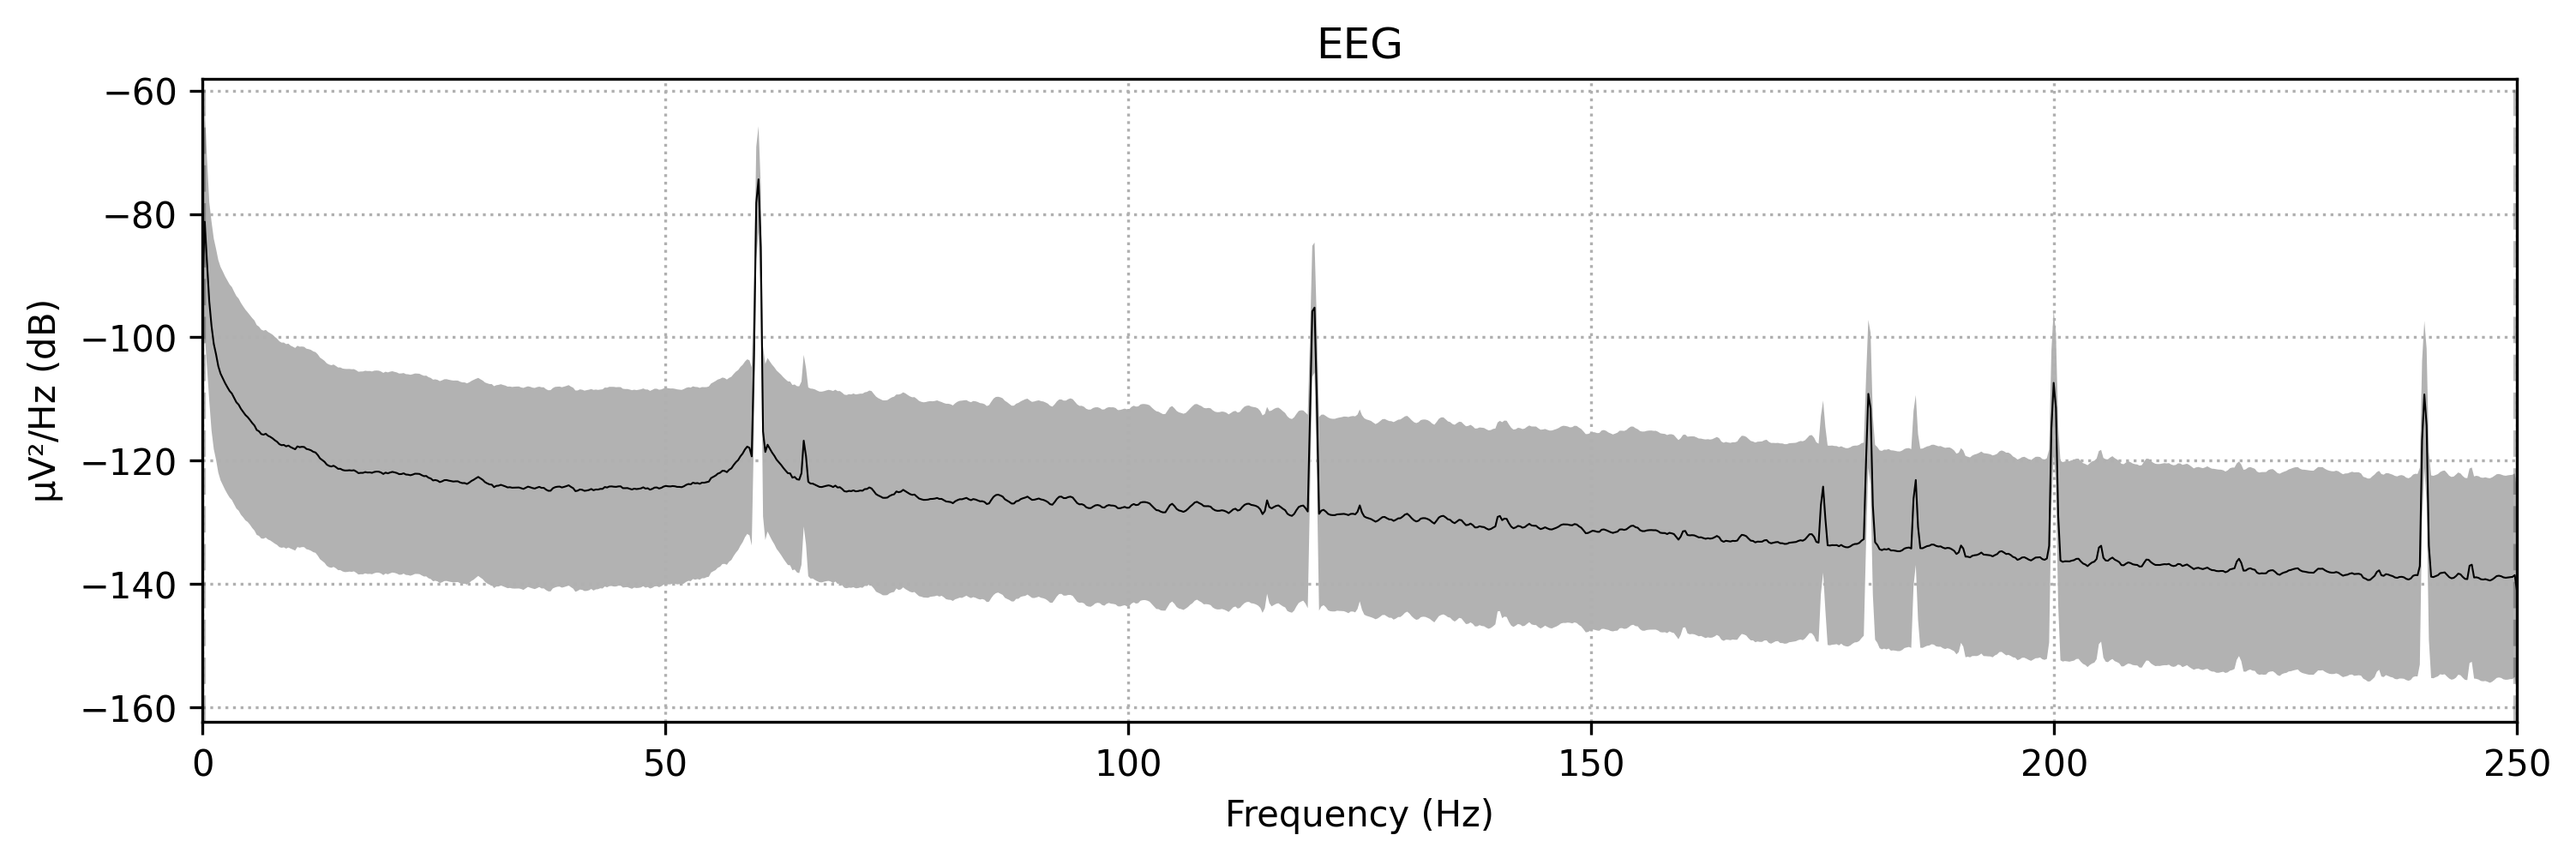

In [8]:
# Visualize the power spectrum of the data
raw.pick(dataChannels).compute_psd(fmax=250).plot(average=True)

In [9]:
# Apply necessary filtering. This may need to be changed for each session. Data
# must be loaded to apply filtering
raw_filtered = raw.copy()
raw_filtered.load_data()

# Apply notch filter to remove noise at 60 and 120 Hz
raw_filtered.pick(dataChannels).notch_filter(freqs=[60, 120])

# Apply bandpass filter to isolate relevant frequencies
raw_filtered.pick(dataChannels).filter(0.5, 100)

Reading 0 ... 485535  =      0.000 ...   971.070 secs...


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (6.602 s)



<RawGDF | record_p-1_b-1_2023-10-24_15-19-46.gdf, 64 x 485536 (971.1 s), ~237.1 MB, data loaded>

Effective window size : 4.096 (s)


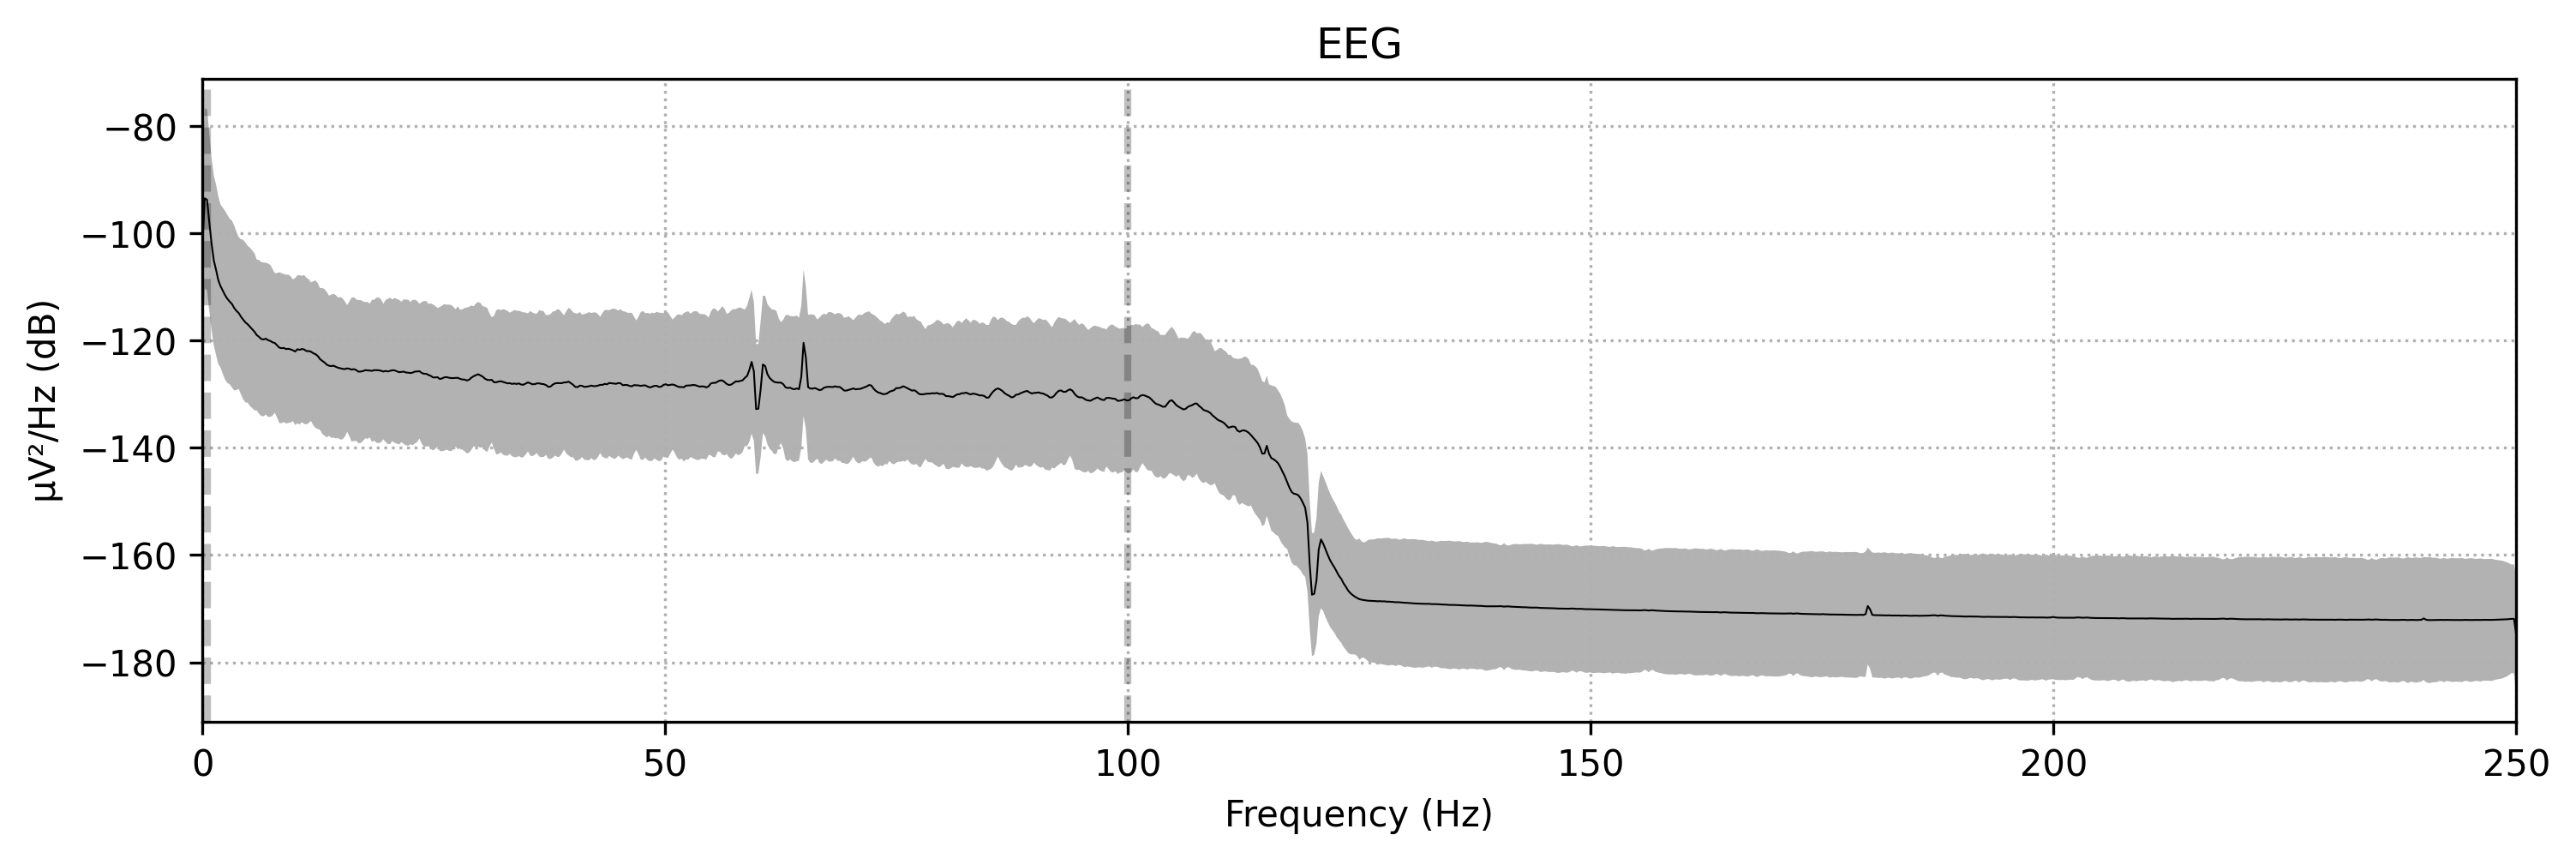

In [10]:
# Visualize the power spectrum of the filtered data
raw_filtered.pick(dataChannels).compute_psd(fmax=250).plot(average=True)

# Epoching
***

## Extract Metadata

In [11]:
# Specify parameters for extracting metadata
timeIntervalPadding = 0.05
tmin = -1 * CONFIG.baseline_duration
tmax = CONFIG.stimulus_duration + CONFIG.break_duration
rowEvents = [x for x in eventDict if x.startswith("visual_stimulus_onset")]

timeIntervalPaddingDur = (tmax - tmin) * timeIntervalPadding / 2

In [12]:
# Extract the metadata and corresponding events and event IDs
metadata, events_md, eventDict_md = mne.epochs.make_metadata(
    events,
    eventDict,
    tmin - timeIntervalPaddingDur,
    tmax + timeIntervalPaddingDur,
    raw_filtered.info["sfreq"],
    row_events=rowEvents,
    keep_first=[
        "visual_stimulus_onset",
        "auditory_stimulus_onset",
        "response"
    ]
)

# Determine congruency
metadata["isCongruent"] = metadata["first_visual_stimulus_onset"].str.extract(
    r"(congruent|noncongruent)",
    expand=False
)

# Determine distractor presence
metadata["isDistractor"] = "nondistractor"
metadata.loc[
    metadata["auditory_stimulus_onset"].notna(),
    "isDistractor"
] = "distractor"

# Display the metadata
metadata

,event_name,OVTK_StimulationId_Number_1B,OVTK_StimulationId_ExperimentStart,OVTK_StimulationId_ExperimentStop,block_start/OVTK_StimulationId_SegmentStart,block_stop/OVTK_StimulationId_SegmentStop,visual_stimulus_end/OVTK_StimulationId_VisualStimulationStop,response/OVTK_StimulationId_Button1_Pressed,response/OVTK_StimulationId_Button2_Pressed,response/OVTK_StimulationId_Button3_Pressed,...,OVTK_GDF_Cross_On_Screen,OVTK_GDF_Incorrect,visual_stimulus_onset,auditory_stimulus_onset,response,first_visual_stimulus_onset,first_auditory_stimulus_onset,first_response,isCongruent,isDistractor
43,visual_stimulus_onset/congruent/OVTK_Stimulati...,-1.61,NaN,NaN,-1.50,NaN,2.004,0.766,NaN,NaN,...,-1.500,NaN,0.000,NaN,0.766,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
44,visual_stimulus_onset/congruent/OVTK_Stimulati...,-1.61,NaN,NaN,-1.50,NaN,2.004,0.766,NaN,NaN,...,-1.500,NaN,0.000,NaN,0.766,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
45,visual_stimulus_onset/congruent/OVTK_Stimulati...,-1.61,NaN,NaN,-1.50,NaN,2.004,0.766,NaN,NaN,...,-1.500,NaN,0.000,NaN,0.766,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
46,visual_stimulus_onset/congruent/OVTK_Stimulati...,-1.61,NaN,NaN,-1.50,NaN,2.004,0.766,NaN,NaN,...,-1.500,NaN,0.000,NaN,0.766,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
47,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,-1.51,NaN,1.994,0.756,NaN,NaN,...,-1.510,NaN,-0.010,NaN,0.756,congruent/OVTK_StimulationId_Label_11,None,OVTK_StimulationId_Button1_Pressed,congruent,nondistractor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,3.000,2.002,0.608,NaN,NaN,...,-1.500,NaN,0.000,-1.500,0.608,congruent/OVTK_StimulationId_Label_11,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button1_Pressed,congruent,distractor
4323,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,3.000,2.002,0.608,NaN,NaN,...,-1.500,NaN,0.000,-1.500,0.608,congruent/OVTK_StimulationId_Label_11,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button1_Pressed,congruent,distractor
4324,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,3.000,2.002,0.608,NaN,NaN,...,-1.500,NaN,0.000,-1.500,0.608,congruent/OVTK_StimulationId_Label_11,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button1_Pressed,congruent,distractor
4325,visual_stimulus_onset/congruent/OVTK_Stimulati...,NaN,NaN,NaN,NaN,3.000,2.002,0.608,NaN,NaN,...,-1.500,NaN,0.000,-1.500,0.608,congruent/OVTK_StimulationId_Label_11,OVTK_StimulationId_Label_D2,OVTK_StimulationId_Button1_Pressed,congruent,distractor


## Epoch Data

In [13]:
# Epoch the data using the metadata and corresponding events and event IDs
epochs = mne.Epochs(
    raw_filtered,
    events_md,
    event_id=eventDict_md,
    tmin=CONFIG.epoching["tmin"],
    tmax=CONFIG.epoching["tmax"],
    metadata=metadata,
    event_repeated='drop', # Preferrably don't drop, but sometimes necessary
    preload=True
)

#TODO: drop bad epochs

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 48 columns
408 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 408 events and 1751 original time points ...


0 bad epochs dropped


# Visualizing ERP
***

In [14]:
# Specify parameters for visualizing the data
targetChannels = [f"Channel {x}" for x in [2, 34, 51, 31, 4, 48, 36, 53]]
title = "Participant 1"

# Specify the colors to use for plotting each channel
cm = mpl.colormaps["viridis"].resampled(len(targetChannels))
colors = {chName : color for (chName, color) in zip(targetChannels, cm.colors)}

In [28]:
def prettyPlotEvoked(
        evoked: mne.Evoked, 
        cleanPlot: bool = True,
        ax: mpl.axes.Axes = None,
        colors: dict[str, Any]|str|None = None,
        units: str = "uV",
        title: str|None = None,
        **kwargs
        ) -> (mpl.axes.Axes, dict[str, mpl.lines.Line2D]):
    _fig, _ax = ax.get_figure(), ax if ax is not None else plt.subplots()
    
    chNames = evoked.ch_names
    if len(set(chNames)) != len(chNames):
        raise ValueError("Channel names must be unique")
    
    # Get color for each channel
    if isinstance(colors, dict):
        _colors = colors
    elif colors is None or isinstance(colors, str):
        cmName = colors if isinstance(colors, str) else "viridis" # by default
        cm = mpl.colormaps[cmName].resampled(len(chNames))
        _colors = {k : v for (k, v) in zip(chNames, cm.colors)}
    else:
        raise ValueError(
            f"Invalid type for argument `colors`: {type(colors)}"
        )
    
    # Do not pass color as additional kwarg, it is handled seperately
    kwargs.pop("color", None)
    
    # Plot the data
    lines = {}  
    data = evoked.get_data(units=units)
    for k, chName in enumerate(chNames):
        lines[chName] = _ax.plot(
            evoked.times,
            data[k],
            label=chName,
            color=_colors[chName],
            **kwargs
        )
        
    # Clean up the plot
    if cleanPlot:
        _ax.set_xlabel("Time (s)")
        _ax.set_ylabel(units)
        _ax.set_title(
            "$N_{ave}=" + str(evoked.nave) + "$", 
            loc="right", 
        )
        _ax.set_title(title)
        
    return _ax, lines

In [30]:
isCongruent, isDistractor = np.meshgrid(
    ["Congruent", "Noncongruent"], 
    ["Distractor", "Nondistractor"],
)
rows, cols = np.indices(isCongruent.shape)

fig = plt.figure(layout="constrained")
axs = fig.subplots(len(cols), len(rows), sharex=True, sharey=True)

# Plot ERP for every combination of experimental conditions
for r, c in np.nditer([rows, cols]):
    
    # Select the subset of the epochs for this combination of experimental
    # conditions
    subset = epochs[
        f"isCongruent == '{isCongruent[r,c].lower()}'" +
        f"& isDistractor == '{isDistractor[r,c].lower()}'"
    ]
    
    # Average target channels over epochs
    evoked = subset.pick(targetChannels).average()
    
    # Plot the ERP
    prettyPlotEvoked(evoked, ax=axs[r,c], colors=colors)
    
    # Add lines at y=0 and x=0
    axs[r,c].axhline(0, ls="dotted", lw=0.75, color="gray")
    axs[r,c].axvline(0, ls=(0, (10, 10)), lw=0.75, color="gray")
    
    # Clean up the figure
    # Handle axis labels
    isLastRow = (r == np.max(rows))
    isFirstCol = (c == np.min(cols))
    if isLastRow and isFirstCol:
        # Move axis labels to spread over all rows/columns
        fig.supxlabel(axs[r,c].get_xlabel())
        fig.supylabel(axs[r,c].get_ylabel())
    # Label the experimental conditions corresponding to each row/column
    axs[r,c].set_xlabel(isCongruent[r,c] if isLastRow else None)
    axs[r,c].set_ylabel(isDistractor[r,c] if isFirstCol else None)
    # Remove title of every plot
    axs[r,c].set_title(None)
    
fig.suptitle(title)
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right center")
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
